# Method: Confidence Regions for Level Sets (Take 1)

Code to explore the performance of a method to draw confidence regions for level sets of the survival function. Goal: to extrapolate these regions out into the tail of the distribution using EVT.

## General Possible Stories to Tell

Collection of possible angles to explore/framings for the research, that would make a good publishable story.

+ Use method to draw uncertainty region for really small p, but show that maybe it has suboptimal coverage/is too wide to be useful, but when drawing a region for higher p and projecting out using EVT, you get better results

+ How far back into the tail should you go to get better results when projecting to a particular level? (i.e. when projecting to a particular level, is it more beneficial to draw the base region closer to that level, or to draw it farther back where there's more data and then project?)

In [53]:
library(mvtnorm)
library(ks)
library(dplyr, warn.conflicts = FALSE)
library(ggplot2)
library(ismev)
library(repr)

In [54]:
res_path <- '/global/cscratch1/sd/jbbutler/sims/regions/'
base_path <- paste0(res_path, 'bases/')
proj_path <- paste0(res_path, 'projections/')

In [55]:
source('/global/u1/j/jbbutler/isolines_uq/scripts/R/utils.R')

# Explorations Set 1

Main characteristics of this explorations set:

1. Use of `kcde` to draw empirical survival functions (binned + FFT-based KDE estimation)
2. Displaying the confidence region as a full set of points on a grid
3. Specifying $\beta_{n}$ as some power of $(1/n)$

#### Note:

Some of the results here use slightly different procedures. While I wouldn't expect it to make that much of a difference, I'm just going to document which results use the current version of the code. Current version refers to the same code being used before, except with `xmin` and `xmax` specified for drawing the empirical survival function using `kcde` and ensuring that the window set contains both the data and the grid on which you wish to draw, and with no adaptive `gridsize` mechanism (just choosing it to be $500$). For the projection code, the main update is that we snap the uncertainty regions to the nearest hundredth by rounding all the points to the nearest hundredth.

1. Both $p = 0.005$ (for $q = 1/3$ and $q = 1/4$) use the current version of the code, except projections do not snap
2. All bivariate t projection results use the oldest version of code (adaptive gridsize and no forced correspondence between evaluated grids in empirical or bootstrap survival functions)
3. All bivariate gauss results use adaptive gridsize and grid correspondence as in the current version of the code, and the projection results use a rounding to the nearest hundredth

## Explorations, Bivariate t

Exploring the coverage rates for $\beta_{n} = (1/n)^{q}$ for different choices of $q > 0$, for different sample sizes $n$ of bivariate t-distributed data.

There are a few things to try, but going to guide my explorations around different $\beta_{n}$ functions, and for each $\beta_{n}$, looking at coverage rates for increasing $n$ for different $p_{base}$ and $p_{proj}$.

### Fix $\beta_{n} = (1/n)^{1/3}$

#### $p_{base} = 0.05$, and projections

In [3]:
# load up the base files to get base coverages

all_folders <- list.files(path = base_path)
specifiers <- c('0.333q', 'bivt', '0.05pbase')
ns <- c()
covs <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(base_path, folder))
        
        setwd(paste0(base_path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
            
    }
}

In [4]:
res_df1 <- data.frame(ns = ns, base_cov = covs)
res_df1 <- arrange(res_df1, ns)

In [5]:
# load up the base files to get projections

all_folders <- list.files(path = proj_path)
specifiers <- c('0.333q', 'bivt', '0.01pproj')
ns <- c()
covs <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(proj_path, folder))
        
        setwd(paste0(proj_path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
        
    }
    
}

In [6]:
res_df2 <- data.frame(ns = ns, proj_cov = covs)
res_df2 <- arrange(res_df2, ns)

In [7]:
# load up the base files to get projections

all_folders <- list.files(path = proj_path)
specifiers <- c('0.333q', 'bivt', '0.005pproj')
ns <- c()
covs <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(proj_path, folder))
        
        setwd(paste0(proj_path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
        
    }
    
}

In [8]:
res_df3 <- data.frame(ns = ns, proj_cov = covs)
res_df3 <- arrange(res_df3, ns)

In [9]:
res_df_0.333_0.05 <- res_df1 %>% mutate(proj_cov0.01 = res_df2$proj_cov) %>% mutate(proj_cov0.005 = res_df3$proj_cov) %>% rename(base_cov0.05 = base_cov)


In [10]:
res_df_0.333_0.05

ns,base_cov0.05,proj_cov0.01,proj_cov0.005
<dbl>,<dbl>,<dbl>,<dbl>
1000,1,0.834,0.688
3000,1,0.936,0.812
5000,1,0.968,0.896
10000,1,0.998,0.966
15000,1,1.000,0.986
20000,1,1.000,0.998


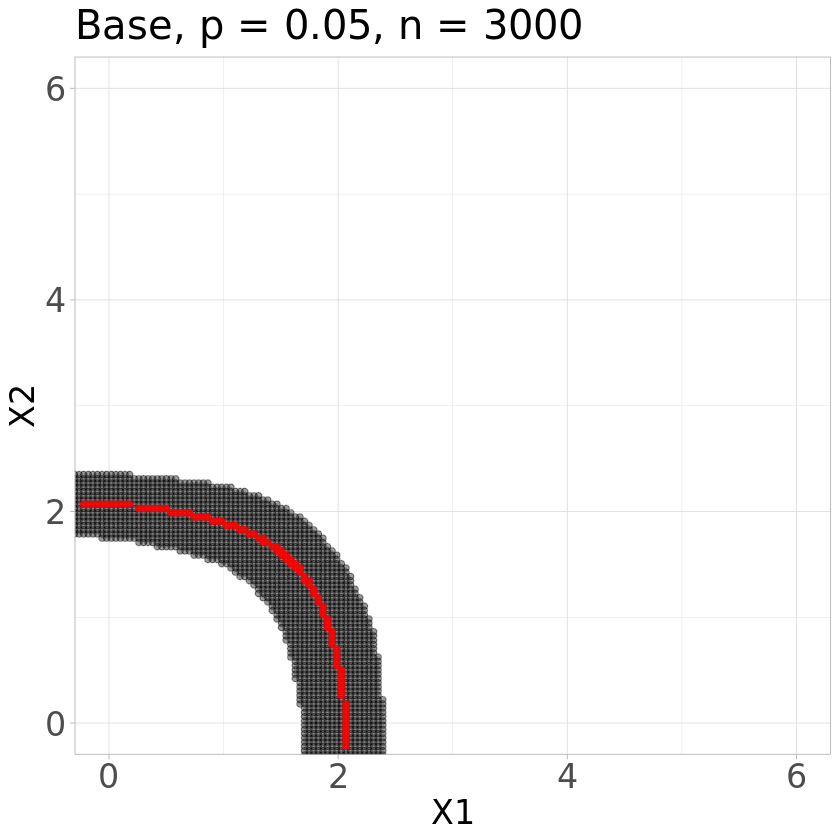

In [161]:
i <- 29

res <- readRDS(paste0(base_path, '3000n_500B_0.05pbase_0.333q_bivt_confregs/',i,'_3000n_500B_0.05pbase_0.333q_bivt_confregs.RData'))

orig_plt <- ggplot() + 
geom_point(dat = res[[1]][[1]], aes(x = X1, y = X2), alpha = 0.4) + 
geom_point(dat = res[[2]], aes(x = X1, y = X2), col = 'red', alpha = 0.8) + 
coord_cartesian(ylim=c(0, 6), xlim = c(0, 6)) + ggtitle(paste0('Base, ', 'p = ', res$orig_out$p, ', n = ', nrow(res[[1]][[3]]))) + theme_light() + 
xlab('X1') + ylab('X2') + theme(axis.title = element_text(size = 20), axis.text = element_text(size = 20), text = element_text(size = 20))
orig_plt

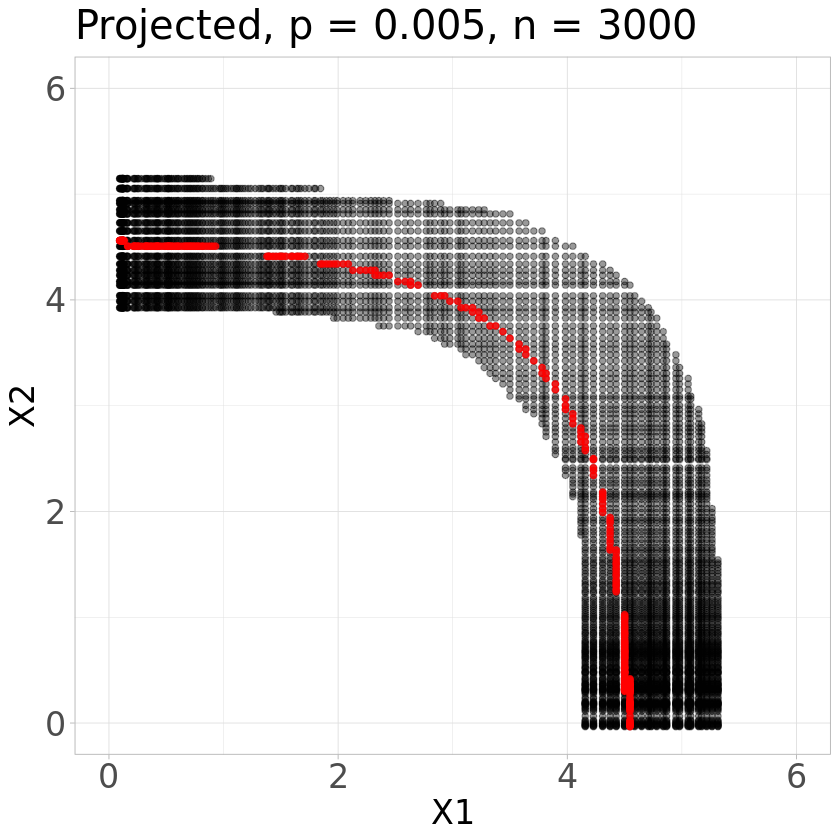

In [171]:
i <- 109

res <- readRDS(paste0(proj_path, '3000n_500B_0.05pbase_0.005pproj_0.333q_bivt_confregs/', i, '_3000n_500B_0.05pbase_0.005pproj_0.333q_bivt_confregs.RData'))

orig_plt <- ggplot() + 
geom_point(dat = res[[1]][[3]], aes(x = X1, y = X2), alpha = 0.4) + 
geom_point(dat = res[[2]], aes(x = X1, y = X2), col = 'red', alpha = 0.8) + 
coord_cartesian(ylim=c(0, 6), xlim = c(0, 6)) + ggtitle(paste0('Projected, ', 'p = ', res[[1]]$proj_p, ', n = ', nrow(res[[1]][[1]][[3]]))) + theme_light() + 
xlab('X1') + ylab('X2') + theme(axis.title = element_text(size = 20), axis.text = element_text(size = 20), text = element_text(size = 20))
orig_plt

In [163]:
res

#### $p = 0.005$

Note that the results produced here used somewhat different code than the results above (for any other pbase). Specifically, we set xmin and xmax in kcde such that the grid for binned estimation always encompasses the grid on which we are estimating. Additionally, we no longer use a data-adaptive choice of gridsize, but rather just have it be large enough (around 500).

In [11]:
# load up the base files to get base coverages

all_folders <- list.files(path = base_path)
specifiers <- c('0.333q', 'bivt', '0.005pbase')
ns <- c()
covs <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(base_path, folder))
        
        setwd(paste0(base_path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
            
    }
}

In [12]:
res_df1 <- data.frame(ns = ns, base_cov = covs)
res_df1 <- arrange(res_df1, ns)

In [13]:
res_df_0.333_0.005 <- res_df1

In [132]:
res_df_0.333_0.005

ns,base_cov
<dbl>,<dbl>
1000,1
3000,1
5000,1
10000,1
15000,1
20000,1


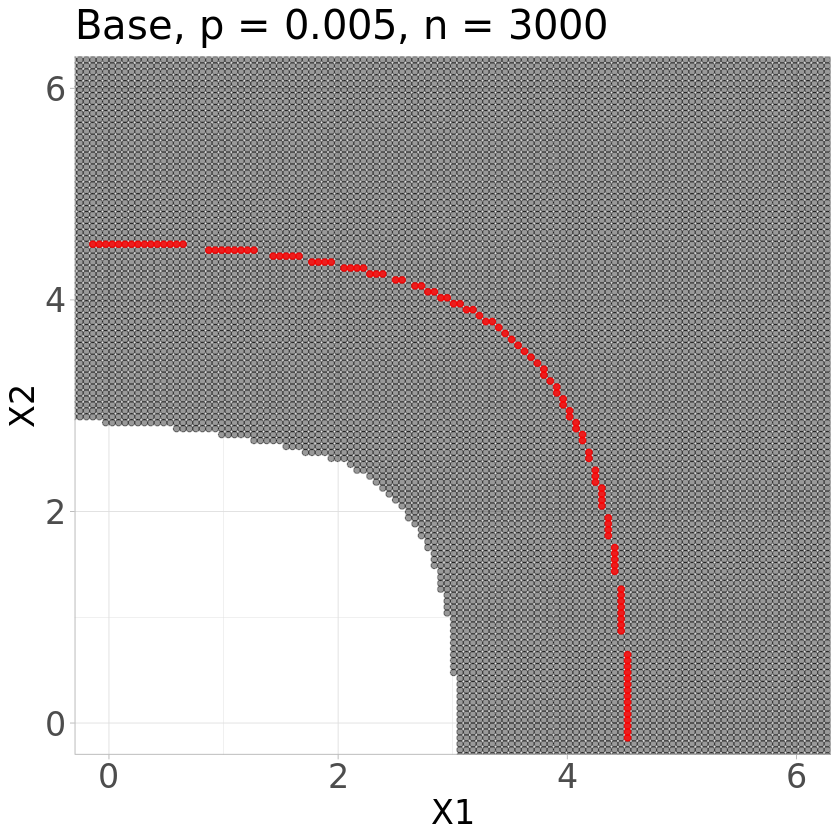

In [172]:
i <- 29

res <- readRDS(paste0(base_path, '3000n_500B_0.005pbase_0.333q_bivt_confregs/',i,'_3000n_500B_0.005pbase_0.333q_bivt_confregs.RData'))

orig_plt <- ggplot() + 
geom_point(dat = res[[1]][[1]], aes(x = X1, y = X2), alpha = 0.4) + 
geom_point(dat = res[[2]], aes(x = X1, y = X2), col = 'red', alpha = 0.8) + 
coord_cartesian(ylim=c(0, 6), xlim = c(0, 6)) + ggtitle(paste0('Base, ', 'p = ', res$orig_out$p, ', n = ', nrow(res[[1]][[3]]))) + theme_light() + 
xlab('X1') + ylab('X2') + theme(axis.title = element_text(size = 20), axis.text = element_text(size = 20), text = element_text(size = 20))
orig_plt

### Fix $\beta_{n} = (1/n)^{1/2}$

#### $p_{base} = 0.05$, and projections

In [14]:
all_folders <- list.files(path = base_path)
specifiers <- c('0.5q', 'bivt')
ns <- c()
covs <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(base_path, folder))
        
        setwd(paste0(base_path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
            
    }
}

In [15]:
res_df1 <- data.frame(ns = ns, base_cov = covs)
res_df1 <- arrange(res_df1, ns)

In [16]:
res_df_0.5_0.05 <- res_df1

In [133]:
res_df_0.5_0.05

ns,base_cov
<dbl>,<dbl>
1000,0.992
3000,0.992
5000,0.996
10000,1.000
15000,1.000
20000,1.000


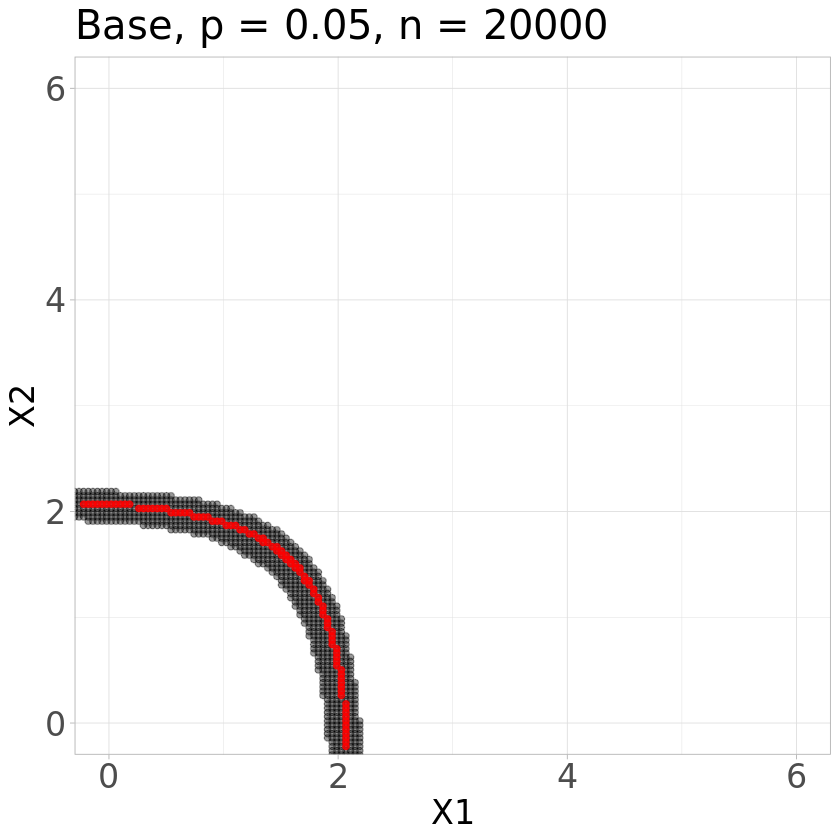

In [160]:
i <- 29

res <- readRDS(paste0(base_path, '20000n_500B_0.05pbase_0.5q_bivt_confregs/',i,'_20000n_500B_0.05pbase_0.5q_bivt_confregs.RData'))

orig_plt <- ggplot() + 
geom_point(dat = res[[1]][[1]], aes(x = X1, y = X2), alpha = 0.4) + 
geom_point(dat = res[[2]], aes(x = X1, y = X2), col = 'red', alpha = 0.8) + 
coord_cartesian(ylim=c(0, 6), xlim = c(0, 6)) + ggtitle(paste0('Base, ', 'p = ', res$orig_out$p, ', n = ', nrow(res[[1]][[3]]))) + theme_light() + 
xlab('X1') + ylab('X2') + theme(axis.title = element_text(size = 20), axis.text = element_text(size = 20), text = element_text(size = 20))
orig_plt

### Fix $\beta_{n} = (1/n)^{1/4}$

#### $p_{base} = 0.05$, and projections

In [17]:
# load up the base files to get base coverages

all_folders <- list.files(path = base_path)
specifiers <- c('0.25q', 'bivt', '0.05pbase')
ns <- c()
covs <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(base_path, folder))
        
        setwd(paste0(base_path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
            
    }
}

In [18]:
res_df1 <- data.frame(ns = ns, base_cov = covs)
res_df1 <- arrange(res_df1, ns)

In [19]:
all_folders <- list.files(path = proj_path)
specifiers <- c('0.25q', 'bivt', '0.01pproj')
ns <- c()
covs <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(proj_path, folder))
        
        setwd(paste0(proj_path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
        
    }
    
}

In [20]:
res_df2 <- data.frame(ns = ns, proj_cov = covs)
res_df2 <- arrange(res_df2, ns)

In [21]:
all_folders <- list.files(path = proj_path)
specifiers <- c('0.25q', 'bivt', '0.005pproj')
ns <- c()
covs <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(proj_path, folder))
        
        setwd(paste0(proj_path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
        
    }
    
}

In [22]:
res_df3 <- data.frame(ns = ns, proj_cov = covs)
res_df3 <- arrange(res_df3, ns)

In [23]:
all_folders <- list.files(path = proj_path)
specifiers <- c('0.25q', 'bivt', '0.001pproj')
ns <- c()
covs <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(proj_path, folder))
        
        setwd(paste0(proj_path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
        
    }
    
}

In [24]:
res_df4 <- data.frame(ns = ns, proj_cov = covs)
res_df4 <- arrange(res_df4, ns)

In [25]:
res_df_0.25_0.05 <- res_df1 %>% mutate(proj_cov0.01 = res_df2$proj_cov) %>% mutate(proj_cov0.005 = res_df3$proj_cov) %>% mutate(proj_cov0.001 = res_df4$proj_cov) %>% rename(base_cov0.05 = base_cov)



In [26]:
res_df_0.25_0.05

ns,base_cov0.05,proj_cov0.01,proj_cov0.005,proj_cov0.001
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000,1,0.944,0.816,0.384
3000,1,0.994,0.956,0.534
5000,1,0.998,0.986,0.668
10000,1,1.000,0.998,0.868
15000,1,1.000,1.000,0.936
20000,1,1.000,1.000,0.966


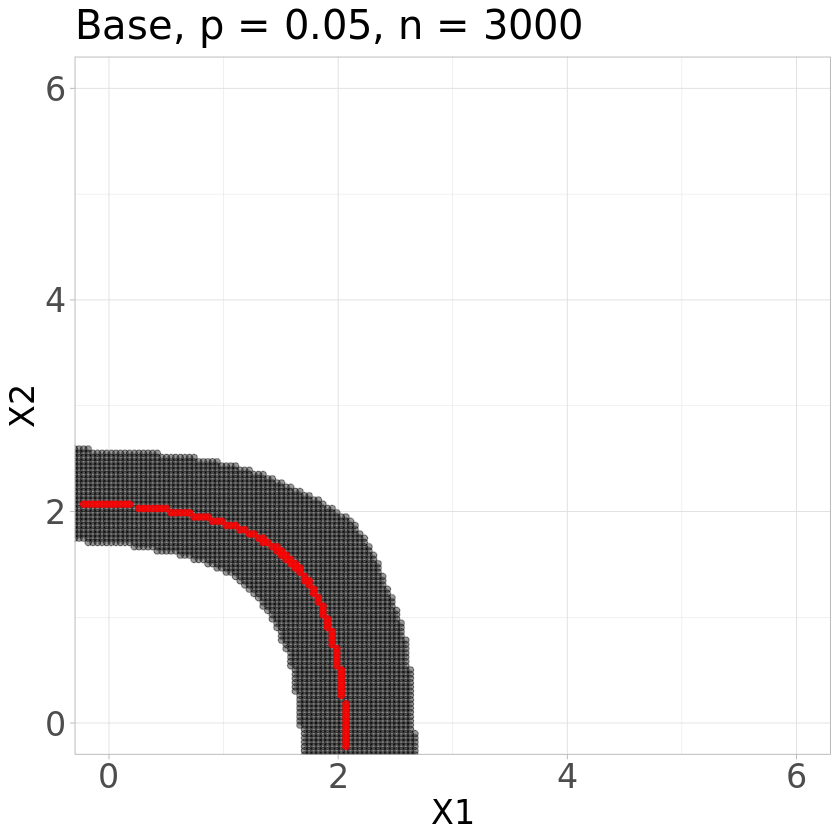

In [173]:
i <- 29

res <- readRDS(paste0(base_path, '3000n_500B_0.05pbase_0.25q_bivt_confregs/',i,'_3000n_500B_0.05pbase_0.25q_bivt_confregs.RData'))

orig_plt <- ggplot() + 
geom_point(dat = res[[1]][[1]], aes(x = X1, y = X2), alpha = 0.4) + 
geom_point(dat = res[[2]], aes(x = X1, y = X2), col = 'red', alpha = 0.8) + 
coord_cartesian(ylim=c(0, 6), xlim = c(0, 6)) + ggtitle(paste0('Base, ', 'p = ', res$orig_out$p, ', n = ', nrow(res[[1]][[3]]))) + theme_light() + 
xlab('X1') + ylab('X2') + theme(axis.title = element_text(size = 20), axis.text = element_text(size = 20), text = element_text(size = 20))
orig_plt

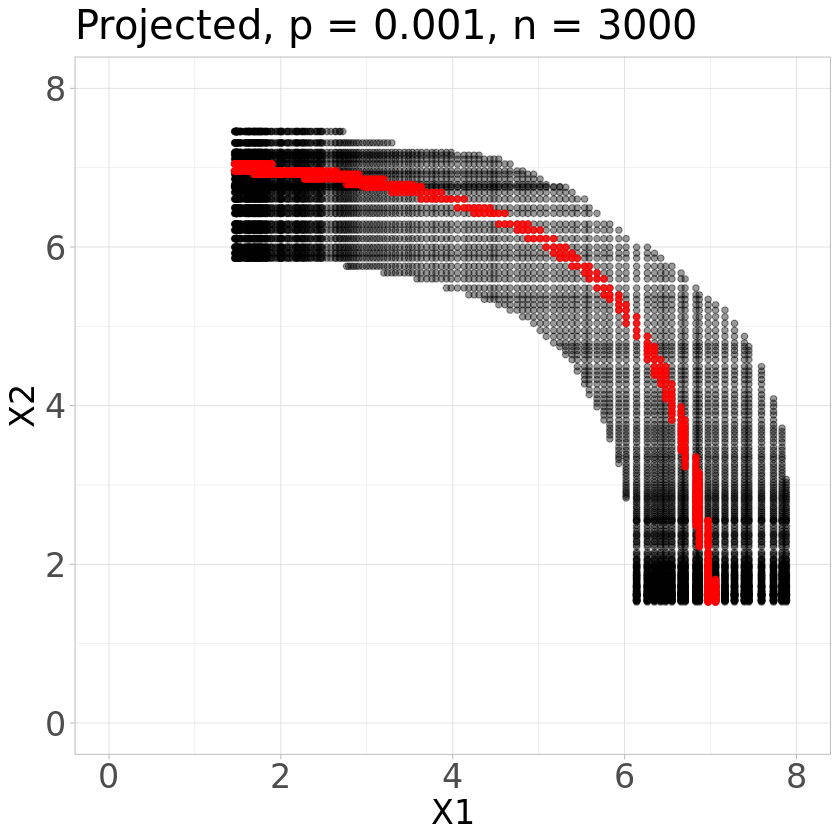

In [179]:
i <- 39

res <- readRDS(paste0(proj_path, '3000n_500B_0.05pbase_0.001pproj_0.25q_bivt_confregs/', i, '_3000n_500B_0.05pbase_0.001pproj_0.25q_bivt_confregs.RData'))

orig_plt <- ggplot() + 
geom_point(dat = res[[1]][[3]], aes(x = X1, y = X2), alpha = 0.4) + 
geom_point(dat = res[[2]], aes(x = X1, y = X2), col = 'red', alpha = 0.8) + 
coord_cartesian(ylim=c(0, 8), xlim = c(0, 8)) + ggtitle(paste0('Projected, ', 'p = ', res[[1]]$proj_p, ', n = ', nrow(res[[1]][[1]][[3]]))) + theme_light() + 
xlab('X1') + ylab('X2') + theme(axis.title = element_text(size = 20), axis.text = element_text(size = 20), text = element_text(size = 20))
orig_plt

#### $p_{base} = 0.005$

Note that the results produced here used somewhat different code than the results above (for any other pbase). Specifically, we set xmin and xmax in kcde such that the grid for binned estimation always encompasses the grid on which we are estimating. Additionally, we no longer use a data-adaptive choice of gridsize, but rather just have it be large enough (around 500).

In [121]:
# load up the base files to get base coverages

all_folders <- list.files(path = base_path)
specifiers <- c('0.25q', 'bivt', '0.005pbase')
ns <- c()
covs <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(base_path, folder))
        
        setwd(paste0(base_path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
            
    }
}

In [122]:
res_df1 <- data.frame(ns = ns, base_cov = covs)
res_df1 <- arrange(res_df1, ns)

In [125]:
res_df_0.25_0.005 <- res_df1

In [126]:
res_df_0.25_0.005

ns,base_cov
<dbl>,<dbl>
1000,1
3000,1
5000,1
10000,1
15000,1
20000,1


In [185]:
res$o

[1] "orig_out"   "isoline"    "is_covered"

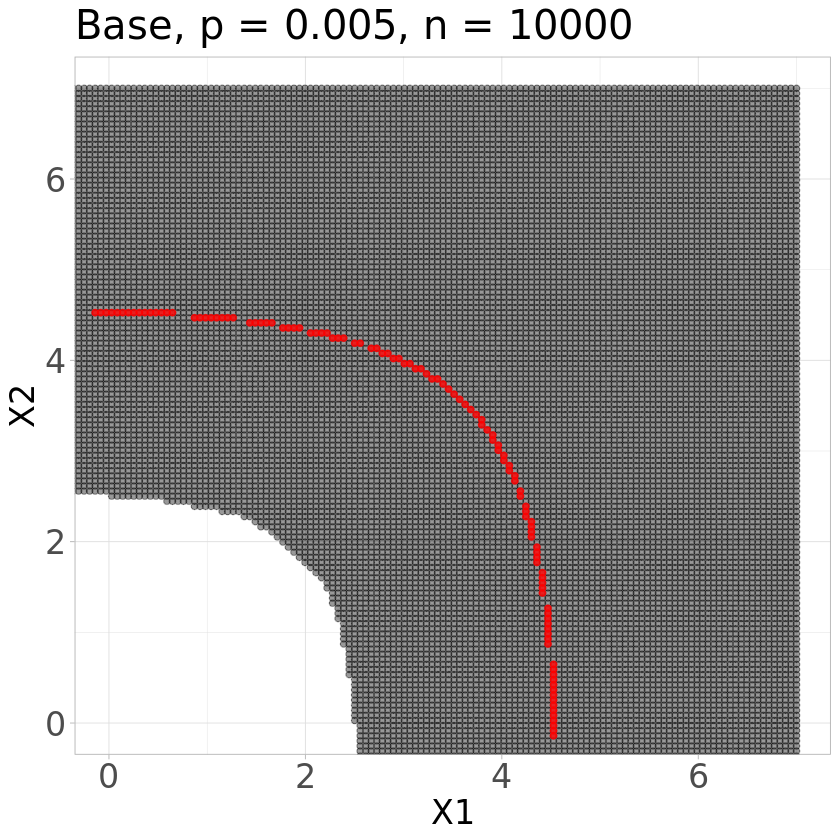

In [187]:
i <- 12
res <- readRDS(paste0(base_path, '10000n_500B_0.005pbase_0.25q_bivt_confregs/',i,'_10000n_500B_0.005pbase_0.25q_bivt_confregs.RData'))

orig_plt <- ggplot() + 
geom_point(dat = res[[1]][[1]], aes(x = X1, y = X2), alpha = 0.4) + 
geom_point(dat = res[[2]], aes(x = X1, y = X2), col = 'red', alpha = 0.8) + 
coord_cartesian(ylim=c(0, 7), xlim = c(0, 7)) + ggtitle(paste0('Base, ', 'p = ', res$orig_out$p, ', n = ', nrow(res[[1]][[3]]))) + theme_light() + 
xlab('X1') + ylab('X2') + theme(axis.title = element_text(size = 20), axis.text = element_text(size = 20), text = element_text(size = 20))
orig_plt

In [ ]:
i <- 290

res <- readRDS(paste0(proj_path, '1000n_500B_0.05pbase_0.005pproj_0.25q_bivt_confregs/', i, '_1000n_500B_0.05pbase_0.005pproj_0.25q_bivt_confregs.RData'))

orig_plt <- ggplot() + 
geom_point(dat = res[[1]][[3]], aes(x = X1, y = X2), alpha = 0.4) + 
geom_point(dat = res[[2]], aes(x = X1, y = X2), col = 'red', alpha = 0.8) + 
coord_cartesian(ylim=c(0, 8), xlim = c(0, 8)) + ggtitle(paste0('Projected, ', 'p = ', res[[1]]$proj_p, ', n = ', nrow(res[[1]][[1]][[3]]))) + theme_light() + 
xlab('X1') + ylab('X2') + theme(axis.title = element_text(size = 20), axis.text = element_text(size = 20), text = element_text(size = 20))
orig_plt

In [ ]:
i <- 100

res <- readRDS(paste0(base_path, '1000n_500B_0.005pbase_0.333q_bivt_confregs/49_1000n_500B_0.005pbase_0.333q_bivt_confregs.RData'))

orig_plt <- ggplot() + 
geom_point(dat = res[[1]][[1]], aes(x = X1, y = X2), alpha = 0.4) + 
geom_point(dat = res[[2]], aes(x = X1, y = X2), col = 'red', size = 4, alpha = 0.8) + 
coord_cartesian(ylim=c(0, 6), xlim = c(0, 6)) + ggtitle(paste0('Projected, ', 'p = ', res[[1]]$proj_p, ', n = ', nrow(res[[1]][[3]]))) + theme_light() + 
xlab('X1') + ylab('X2') + theme(axis.title = element_text(size = 20), axis.text = element_text(size = 20), text = element_text(size = 20))
orig_plt

## Explorations, Bivariate Gaussian

Exploring the coverage rates for $\beta_{n} = (1/n)^{q}$ for different choices of $q > 0$, for different sample sizes $n$ of bivariate gaussian data. 

Note for these bivariate gaussian results, we used slightly different code than what we used above. Specifically, we set xmin and xmax in the original cdf estimation to be such that it always encompasses the data and the grid we are drawing on. Additionally, we used a gridsize that was adaptive to data size and much larger than 250. Finally, we are rounding the projected isolines to the nearest 2nd decimal place, since otherwise the size of the grid is much too large. In a few small cases it doesn't seem to make that big of a difference.

### Results look god-awful...

Although, I think there might be a bug in what's being counted as a cover or not, because some isolines certainly look covered but were marked as false. Will look into this.

However, it does seem like once again there is an issue with bias near the edges of the grid. Probably can be rectified by doing something else (changing some params, etc.), but with the default params from the paper it's not good. 

Maybe can just say that there is bias along the edges that should be corrected, but if we restrict ourselves to some lower bounded region of $\mathbb{R}^{2}$, we can get pretty good confidence regions for the isolines. Interpretation is that the region would contain the collection of events with humidity and heat both higher than some amount with a certain probability. Uncertainty about deadly events, which is what we wanted, right?

### Fix $\beta_{n} = (1/n)^{1/2}$

#### $p_{base} = 0.05$, and projections

In [27]:
# load up the base files to get base coverages

all_folders <- list.files(path = base_path)
specifiers <- c('0.5q', 'bivgauss', '0.05pbase')
ns <- c()
covs <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(base_path, folder))
        
        setwd(paste0(base_path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
            
    }
}

In [28]:
res_df1 <- data.frame(ns = ns, base_cov = covs)
res_df1 <- arrange(res_df1, ns)

In [29]:
all_folders <- list.files(path = proj_path)
specifiers <- c('0.5q', 'bivgauss', '0.01pproj')
ns <- c()
covs <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(proj_path, folder))
        
        setwd(paste0(proj_path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
        
    }
    
}

In [30]:
res_df2 <- data.frame(ns = ns, proj_cov = covs)
res_df2 <- arrange(res_df2, ns)

In [31]:
res_df_0.5_0.05_gauss <- res_df1 %>% mutate(proj_cov0.01 = res_df2$proj_cov) %>% rename(base_cov0.05 = base_cov)

In [42]:
res_df_0.5_0.05_gauss

ns,base_cov0.05,proj_cov0.01
<dbl>,<dbl>,<dbl>
1000,0.984,0.004
3000,0.992,0.000
5000,0.990,0.000
10000,1.000,0.000
15000,1.000,0.000
20000,1.000,0.000


Maybe figured out the coverage issue, I think that when you draw the grid, you start including points that are in the interior of the confidence regions but not actually in the confidence set. So, you mess up. I think this should be fixed eventually, and if so, will fix something I wanted to fix down the line anyway.

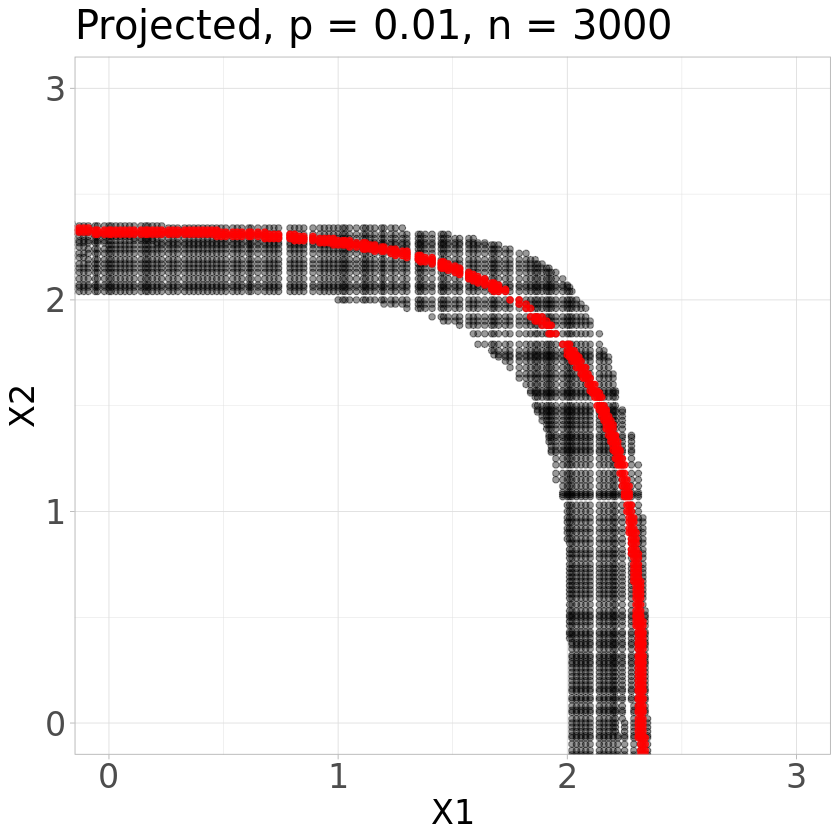

In [193]:
i <- 300

res <- readRDS(paste0(proj_path, '3000n_500B_0.05pbase_0.01pproj_0.25q_bivgauss_confregs/', i, '_3000n_500B_0.05pbase_0.01pproj_0.25q_bivgauss_confregs.RData'))

orig_plt <- ggplot() + 
geom_point(dat = res[[1]][[3]], aes(x = X1, y = X2), alpha = 0.4) + 
geom_point(dat = res[[2]], aes(x = X1, y = X2), col = 'red', alpha = 0.8) + 
coord_cartesian(ylim=c(0, 3), xlim = c(0, 3)) + ggtitle(paste0('Projected, ', 'p = ', res[[1]]$proj_p, ', n = ', nrow(res[[1]][[1]][[3]]))) + theme_light() + 
xlab('X1') + ylab('X2') + theme(axis.title = element_text(size = 20), axis.text = element_text(size = 20), text = element_text(size = 20))
orig_plt

### Fix $\beta_{n} = (1/n)^{1/3}$

In [32]:
# load up the base files to get base coverages

all_folders <- list.files(path = base_path)
specifiers <- c('0.333q', 'bivgauss', '0.05pbase')
ns <- c()
covs <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(base_path, folder))
        
        setwd(paste0(base_path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
            
    }
}

In [33]:
res_df1 <- data.frame(ns = ns, base_cov = covs)
res_df1 <- arrange(res_df1, ns)

In [34]:
all_folders <- list.files(path = proj_path)
specifiers <- c('0.333q', 'bivgauss', '0.01pproj')
ns <- c()
covs <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(proj_path, folder))
        
        setwd(paste0(proj_path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
        
    }
    
}

In [35]:
res_df2 <- data.frame(ns = ns, proj_cov = covs)
res_df2 <- arrange(res_df2, ns)

In [36]:
res_df_0.333_0.05_gauss <- res_df1 %>% mutate(proj_cov0.01 = res_df2$proj_cov) %>% rename(base_cov0.05 = base_cov)

In [43]:
res_df_0.333_0.05_gauss

ns,base_cov0.05,proj_cov0.01
<dbl>,<dbl>,<dbl>
1000,0.998,0.002004008
3000,1.000,0.002000000
5000,1.000,0.000000000
10000,1.000,0.000000000
15000,1.000,0.000000000
20000,1.000,0.000000000


### Fix $\beta_{n} = (1/n)^{1/4}$

In [37]:
# load up the base files to get base coverages

all_folders <- list.files(path = base_path)
specifiers <- c('0.25q', 'bivgauss', '0.05pbase')
ns <- c()
covs <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(base_path, folder))
        
        setwd(paste0(base_path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
            
    }
}

In [38]:
res_df1 <- data.frame(ns = ns, base_cov = covs)
res_df1 <- arrange(res_df1, ns)

In [39]:
all_folders <- list.files(path = proj_path)
specifiers <- c('0.25q', 'bivgauss', '0.01pproj')
ns <- c()
covs <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(proj_path, folder))
        
        setwd(paste0(proj_path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
        
    }
    
}

In [48]:
res_df2 <- data.frame(ns = ns, proj_cov = covs)
res_df2 <- arrange(res_df2, ns)

In [49]:
res_df_0.25_0.05_gauss <- res_df1 %>% mutate(proj_cov0.01 = res_df2$proj_cov) %>% rename(base_cov0.05 = base_cov)

In [50]:
res_df_0.25_0.05_gauss

ns,base_cov0.05,proj_cov0.01
<dbl>,<dbl>,<dbl>
1000,1,0.002
3000,1,0.000
5000,1,0.000
10000,1,0.000
15000,1,0.000
20000,1,0.000
